# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Section - Analysis

## 1. Data Exploration

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [ ]:
# !pip install category_encoders
# !pip install lightgbm
# !pip install xgboost
# !pip install catboost
# ! pip install dataframe-image
#! pip install dataframe-image

In [ ]:
import pandas as pd
import numpy as np
import math
import json
import copy
#% matplotlib inline
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    precision_score, recall_score, f1_score, average_precision_score, \
    roc_auc_score, roc_curve, classification_report
import datetime
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures, LabelEncoder
from category_encoders import WOEEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import xgboost
import dataframe_image as dfi
pd.options.display.max_columns = None

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
transcript.loc[[0,12650],:].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0


In [7]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [8]:
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [9]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [10]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [11]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [12]:
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

## 2. Data Visualization

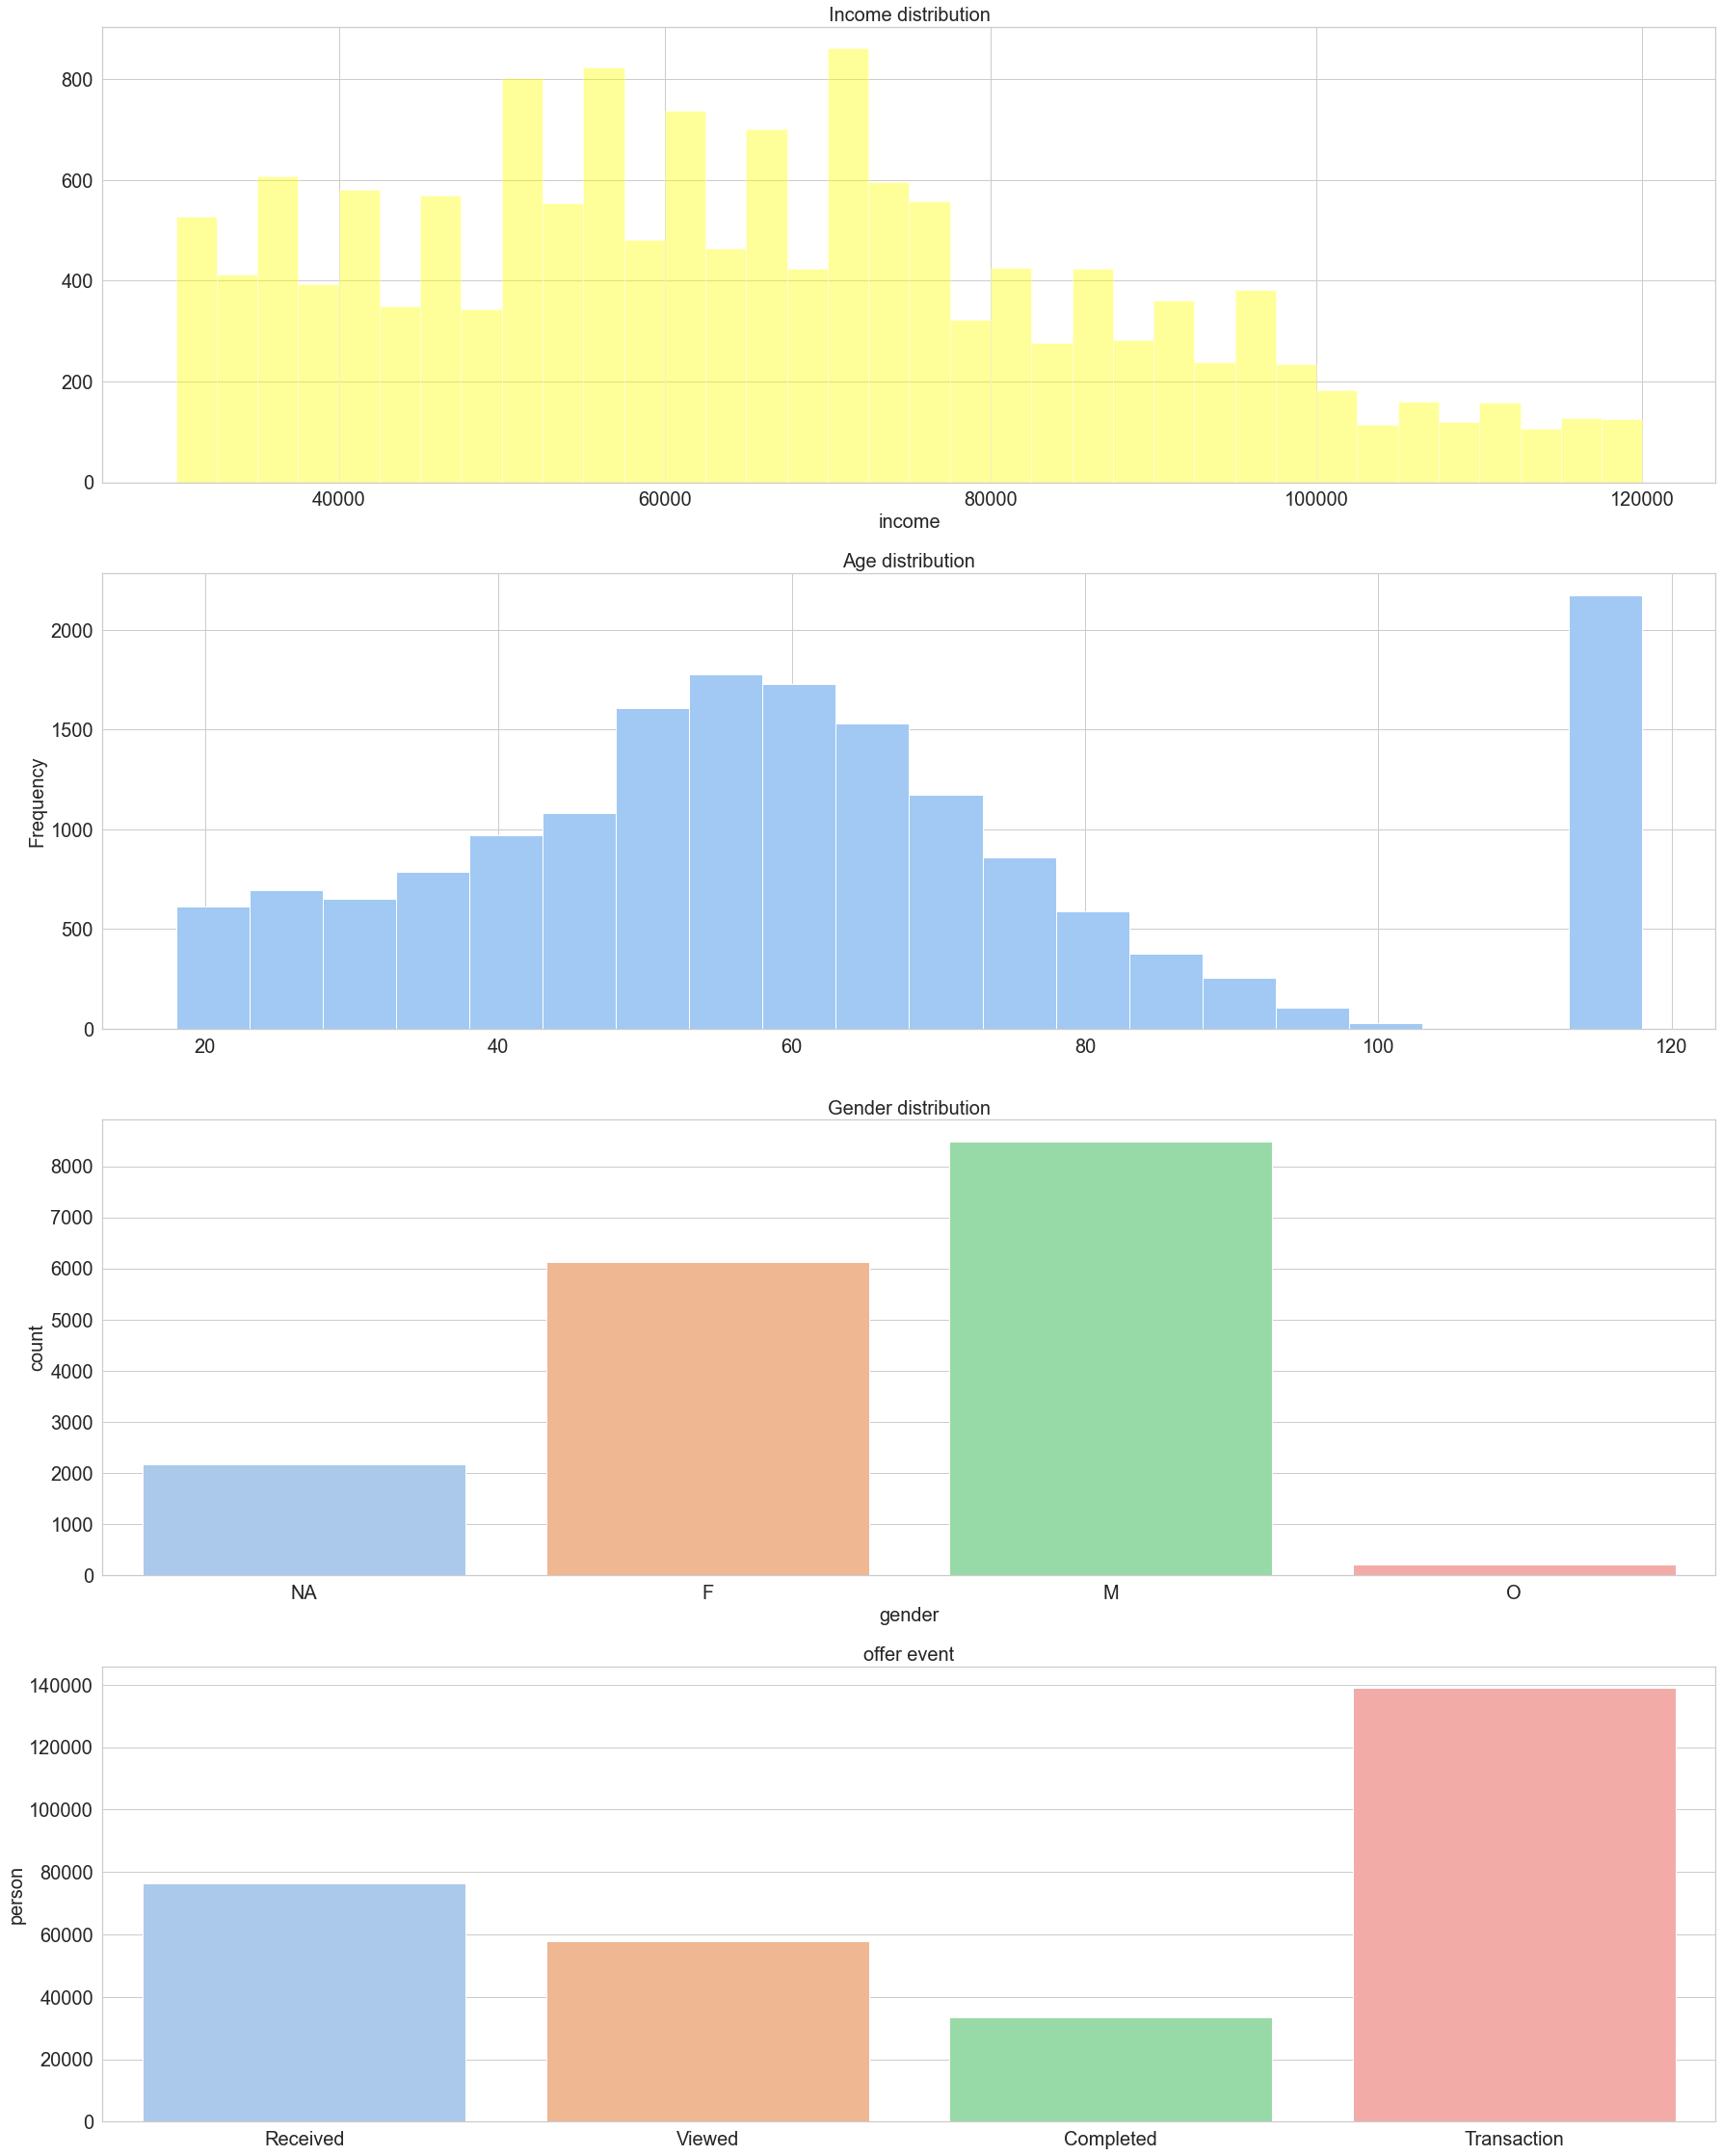

In [13]:
sns.set_theme(style="whitegrid", palette="pastel")
fig, axes = plt.subplots(4, 1, figsize=(30,40))

sns.distplot(ax= axes[0], a=profile['income'], kde=False, color="yellow")
axes[0].set_title('Income distribution',fontsize=20)

profile.age.plot.hist(ax= axes[1], bins=20)
axes[1].set_title('Age distribution',fontsize=20)

sns.countplot(ax= axes[2],data=profile.fillna("NA"), x="gender")
axes[2].set_title('Gender distribution',fontsize=20)

# sns.countplot(ax= axes[3], data=transcript, x="event")
# axes[3].set_title('offer event',fontsize=20)

event_dict = {'offer received': 0,
 'offer viewed': 1,
 'offer completed': 2,
 'transaction': 3}
funnel_plot_df = transcript.copy()
funnel_plot_df.event = funnel_plot_df.event.map(event_dict)
funnel_plot = funnel_plot_df.groupby(["event"]).count().reset_index().drop(["value","time"], axis=1)
sns.barplot(ax= axes[3], y=funnel_plot.person,x=["Received","Viewed","Completed","Transaction"])
axes[3].set_title('offer event',fontsize=20)

#plt.xtickslabels({"Received","Viewed","Completed","Transaction"})


for i in range(axes.shape[0]):
    #for j in range(axes.shape[1]):
#         axes[i,j].xaxis.label.set_size(20)
#         axes[i,j].yaxis.label.set_size(20)
#         plt.setp(axes[i,j].get_xticklabels(), fontsize=20)
#         plt.setp(axes[i,j].get_yticklabels(), fontsize=20)
        axes[i].xaxis.label.set_size(20)
        axes[i].yaxis.label.set_size(20)
        plt.setp(axes[i].get_xticklabels(), fontsize=20)
        plt.setp(axes[i].get_yticklabels(), fontsize=20)

In [14]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [15]:
len(profile.gender)

17000

In [16]:
profile[profile.gender.isna()]["income"].value_counts()

Series([], Name: income, dtype: int64)

In [17]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

# Section - Methodology

## 1 . Data Preprocessing

Summary of the data analysis :
1. There could be some outliers in the age distribution that needs to removed
2. Gender distribution are having extra columns as None and 'Others'. This may need to be removed as well. 
3. There are same numbers of missing data for gender and income. They are found to be of the same rows as upon removing the rows with gender as 'NA'. Count of rows with income == 'NA' have disappeared.
4. if all the offers completed could only come from offers viewed that in turn could only have come from offers that are received, the trend is in line showing a funnel like decreasing trend moving from one to another. 
5. The number of transactions, on the other hand, could only have come from customers who did not use or receive any offers. There might probably be some offer completed counts that are also in transaction counts.

In [18]:
#remove "na" data
profile.dropna(subset=["gender"],inplace=True)

In [19]:
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

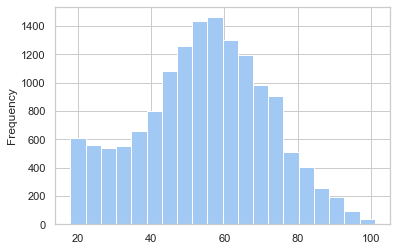

In [20]:
profile.age.plot.hist(bins=20)
plt.show()

Upon checking, the rows with age outliers are now gone, together with the income with "NA" as data. However, the gender that are classified as "others" are yet to be resolved. 

In [21]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Given that the number of gender classified as others is small, it is proposed to have it remove as well. 

In [22]:
profile = profile[~(profile.gender == "O")]

In [23]:
transcript[transcript.person =="78afa995795e4d85b5d9ceeca43f5fef"].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144


The original transcript table captures the offer id that each customer either receives, views or completes in the “value” column. For any transaction, an amount spent is also being stored as a dictionary in the same “value” column. Let's extract the offer id out in a separate columns using the function below.

In [24]:
def split_offer_id_from_value(x,y):
    a= "transaction"
    b = ""
    c= 0
    if set([i for i in x.keys()]).intersection(set(["offer id"]))!=set():
        a= x["offer id"]
    elif set([i for i in x.keys()]).intersection(set(["offer_id"]))!=set():
        a= x["offer_id"]
    elif set([i for i in x.keys()]).intersection(set(["amount"]))!=set() and y =="transaction":
        b= x["amount"]        
    else:
        a = None            
        b= ""
    if set([i for i in x.keys()]).intersection(set(["reward"]))!=set():
        c= x["reward"]
    return [a,b,c]

In [25]:
ext = transcript.apply(lambda x: split_offer_id_from_value(x["value"],x["event"]), axis=1)
ext_df = pd.DataFrame(list(ext),columns = ['offer_id', 'amount_spent','reward_claimed'])

offer_id split from the reward amount

In [26]:
transcript = pd.concat([transcript,ext_df], axis=1)

to check the offer_id split is the same as from the value columns

In [27]:
transcript = transcript.drop(["value"],axis=1)
transcript["amount_spent"] = transcript["amount_spent"].apply(lambda x: x.replace("","0") if x=="" else x)
transcript["amount_spent"] = transcript["amount_spent"].apply(lambda x: float(x))
transcript[transcript.person =="78afa995795e4d85b5d9ceeca43f5fef"].head()

,person,event,time,offer_id,amount_spent,reward_claimed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,transaction,19.89,0
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,5
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,transaction,17.78,0


Now, to look up the personal demographic details of the user. We would need to combine the user_id and offer_id interaction together. This is for treating each user's response to an offer separately. For instance, user A's response to offer A will be recorded as n records even if the user receives n times of the same offer. We want a count column to enumerate the number of times A receives offer A, which can be achieved using the cumcount function

In [28]:
transcript["cum_count"] =transcript.groupby(["person","offer_id",transcript.event=="offer received"]).cumcount()+1

Before going further, the data should be examined for the difference types of completion rates among the offer. 

In [29]:
df_all = transcript.copy(deep=True)
df_all=df_all.merge(profile,left_on="person", right_on="id",how="left").drop(["id"], axis=1)
df_all=df_all.merge(portfolio,left_on="offer_id", right_on="id",how="left").drop(["id"], axis=1)

What can be seen is that the "completed offer" status only captures the discount type offer and the BOGO offer. It is though understandable that the informational offer is not being captured, as technically it may not count as an offer. Hence, we would still need another method to capture the information of how effective the informational offer has been. 

As the dataset is only applicable to ONE product, this makes it easier for the simplification that if a user, views and purchases a drink within the validity period, it can be counted that the effect is felt from the informational offers sent. In contrast, as with the other offers, if the offers are not viewed but purchases are completed within the valid periods, these would not be considered as the effect of the promotional offers. 

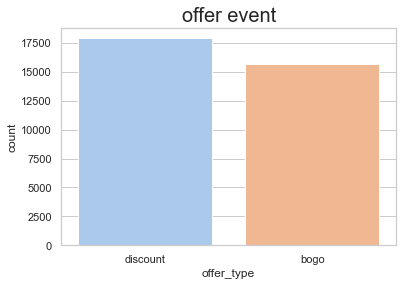

In [30]:
sns.countplot(data=df_all[df_all.event=="offer completed"], x="offer_type").set_title('offer event',fontsize=20)
plt.show()

In [31]:
df_sub = df_all.copy().sort_values(["person","time"]).reset_index()
#df_sub = df_sub.loc[216210:216241]
df_sub["Transaction_From_Offer"] = False
df_sub["Which_Offer"] = 100
df_sub["Related_Offer_Id"] = ""
for i in range(0,16):
    df_sub[f"event_{i}"]= df_sub["event"].shift(i)
    df_sub[f"person_{i}"]= df_sub["person"].shift(i)
    df_sub[f"time_{i}"]= df_sub["time"].shift(i)
    df_sub[f"duration_{i}"]= df_sub["duration"].shift(i)
    df_sub[f"difficulty_{i}"] = df_sub["difficulty"].shift(i)
    df_sub[f"valid_offer_{i}"] = ((df_sub[f"event_{i}"]=="offer received") & (df_sub[f"person_{i}"]==df_sub["person"]) & (df_sub["time"]-df_sub[f"time_{i}"]<=df_sub[f"duration_{i}"])& (df_sub["amount_spent"]>df_sub[f"difficulty_{i}"]))
    df_sub[f"Which_Offer_{i}"] = (df_sub["cum_count"].shift(i))*((df_sub[f"event_{i}"]=="offer received") & (df_sub[f"person_{i}"]==df_sub["person"]))
    df_sub[f"Related_Offer_Id_{i}"] = (df_sub["offer_id"].shift(i))*((df_sub[f"event_{i}"]=="offer received") & (df_sub[f"person_{i}"]==df_sub["person"]))
    df_sub[f"Related_Offer_Id_{i}"].replace(np.NaN,"", inplace=True)
    df_sub[f"Which_Offer_{i}"] = (df_sub[f"Which_Offer_{i}"]==0)*100+df_sub[f"Which_Offer_{i}"]
    df_sub["Related_Offer_Id"] = df_sub["Related_Offer_Id"] + (df_sub["Related_Offer_Id"]=="")*(df_sub[f"Related_Offer_Id_{i}"])
    df_sub["Transaction_From_Offer"] = (df_sub["Transaction_From_Offer"]==True) | (df_sub[f"valid_offer_{i}"]==True)
    df_sub["Transaction_From_Offer"] = (df_sub["Transaction_From_Offer"]==True)  & (df_sub["event"]=="transaction")
    df_sub["Which_Offer"] = df_sub[["Which_Offer",f"Which_Offer_{i}"]].min(axis=1)
    df_sub= df_sub.drop([f"event_{i}",f"person_{i}",f"time_{i}",f"duration_{i}",f"valid_offer_{i}",f"difficulty_{i}",f"Which_Offer_{i}",f"Related_Offer_Id_{i}"], axis=1)

We have populated each transaction with an applicable offer id as the column "Related Offer_Id". As opposed to the raw data, where each transaction related line is having a "Not an Offer" field in the column "Offer_id". As such, let's do a map to the portfolio details once again using the "Related Offer_Id" this time. Before that, it is appropriate to remove the columns of data mapped from the "Offer_id" first. 

In [32]:
df_sub = df_sub.drop(["reward","channels","duration","difficulty","offer_type"], axis=1)
df_sub=df_sub.merge(portfolio,left_on="Related_Offer_Id", right_on="id",how="left").drop(["id"], axis=1)

Adding a membership terms in years

In [33]:
df_sub["membership_terms(y)"] =  datetime.datetime.today().year-pd.to_datetime(df_sub["became_member_on"], format='%Y%m%d').dt.year

In [34]:
df_sub["personxoffer_id"] = df_sub["person"]+df_sub["Related_Offer_Id"]+str(df_sub["Which_Offer"])

In [35]:
df_sub.head()

,index,person,event,time,offer_id,amount_spent,reward_claimed,cum_count,gender,age,became_member_on,income,Transaction_From_Offer,Which_Offer,Related_Offer_Id,reward,channels,difficulty,duration,offer_type,membership_terms(y),personxoffer_id
0,55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.00,0,1,M,33.0,20170421.0,72000.0,False,1.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,5.0,0009655768c64bdeb2e877511632db8f5a8bc65990b245...
1,77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,0.00,0,1,M,33.0,20170421.0,72000.0,False,1.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,5.0,0009655768c64bdeb2e877511632db8f5a8bc65990b245...
2,89291,0009655768c64bdeb2e877511632db8f,transaction,228,transaction,22.16,0,1,M,33.0,20170421.0,72000.0,False,1.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,5.0,0009655768c64bdeb2e877511632db8f5a8bc65990b245...
3,113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,0.00,0,1,M,33.0,20170421.0,72000.0,False,1.0,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,5.0,0009655768c64bdeb2e877511632db8f3f207df678b143...
4,139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,0.00,0,1,M,33.0,20170421.0,72000.0,False,1.0,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,5.0,0009655768c64bdeb2e877511632db8f3f207df678b143...


In [36]:
offer_time = df_sub[["personxoffer_id","time"]][df_sub.event=="offer received"]
offer_time = dict(zip(offer_time.personxoffer_id,offer_time.time))
df_sub["time_of_offer"] = df_sub["personxoffer_id"].map(offer_time)

In [37]:
df_sub["viewed before buy"] = (df_sub.event=="offer viewed")*(df_sub.time-df_sub["time_of_offer"]<=df_sub["duration"])

In [38]:
#find the users who have viewed offers only
respond_1= df_sub[["personxoffer_id","index"]][df_sub["viewed before buy"]==True]
len((respond_1.drop_duplicates()))
respond_1["viewed before buy"] = True
respond_1 = dict(zip(respond_1["personxoffer_id"],respond_1["viewed before buy"]))
respond_2 = df_sub[["personxoffer_id","index"]][df_sub["event"]=="offer viewed"]
respond_2["hasViewed"] = True
respond_2 = dict(zip(respond_2["personxoffer_id"],respond_2["hasViewed"]))
respond_3=df_sub[["personxoffer_id","event"]].copy(deep=True)
respond_3["hasCompleted"] = respond_3.apply(lambda x: True if x["event"]=="offer completed" else False, axis=1)
respond_3 =respond_3.sort_values(["hasCompleted"])
respond_3 =dict(list(zip(respond_3['personxoffer_id'], respond_3['hasCompleted'])))

In [39]:
respond_4 = df_sub[["personxoffer_id","reward_claimed"]][df_sub["reward_claimed"]!=0]
respond_4 =dict(list(zip(respond_4['personxoffer_id'], respond_4['reward_claimed'])))
respond_5 = df_sub[["personxoffer_id","amount_spent"]][df_sub["amount_spent"]!=0]
respond_5 =dict(list(zip(respond_5['personxoffer_id'], respond_5['amount_spent'])))

In [40]:
df_sub["hasViewed_on_time"] = df_sub["personxoffer_id"].map(respond_1)
df_sub["hasViewed_on_time"].replace(np.NaN,False,inplace=True)
df_sub["hasViewed"] = df_sub["personxoffer_id"].map(respond_2)
df_sub["hasViewed"].replace(np.NaN,False,inplace=True)
df_sub["hasCompleted"] = df_sub["personxoffer_id"].map(respond_3)
df_sub["hasCompleted"].replace(np.NaN,False,inplace=True)
df_sub = df_sub.drop(["viewed before buy"], axis =1)
df_sub["reward_claimed"] = df_sub["personxoffer_id"].map(respond_4)
df_sub["reward_claimed"].replace(np.NaN,0,inplace=True)
df_sub["amount_spent"] = df_sub["personxoffer_id"].map(respond_5)
df_sub["amount_spent"].replace(np.NaN,0,inplace=True)

In [41]:
df_sub.head()

,index,person,event,time,offer_id,amount_spent,reward_claimed,cum_count,gender,age,became_member_on,income,Transaction_From_Offer,Which_Offer,Related_Offer_Id,reward,channels,difficulty,duration,offer_type,membership_terms(y),personxoffer_id,time_of_offer,hasViewed_on_time,hasViewed,hasCompleted
0,55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,1,M,33.0,20170421.0,72000.0,False,1.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,5.0,0009655768c64bdeb2e877511632db8f5a8bc65990b245...,168.0,False,True,False
1,77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,1,M,33.0,20170421.0,72000.0,False,1.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,5.0,0009655768c64bdeb2e877511632db8f5a8bc65990b245...,168.0,False,True,False
2,89291,0009655768c64bdeb2e877511632db8f,transaction,228,transaction,22.16,0.0,1,M,33.0,20170421.0,72000.0,False,1.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,5.0,0009655768c64bdeb2e877511632db8f5a8bc65990b245...,168.0,False,True,False
3,113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,0.00,0.0,1,M,33.0,20170421.0,72000.0,False,1.0,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,5.0,0009655768c64bdeb2e877511632db8f3f207df678b143...,336.0,False,True,False
4,139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,0.00,0.0,1,M,33.0,20170421.0,72000.0,False,1.0,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,5.0,0009655768c64bdeb2e877511632db8f3f207df678b143...,336.0,False,True,False


In [42]:
df_sub["transaction_completed"] = df_sub.apply(lambda x: True if x["event"]=="transaction" else x["hasCompleted"] , axis=1)

In [43]:
df_sub["hasViewed"].replace(np.NaN,False,inplace=True)

We can take some time to digest the meaning of "hasViewed", "hasViewed_on_time" and "hasCompleted". Imagine if an offer is sent to a user's app inbox with a validity of 7 days. However, the user only checked out the offer and managed to view the offer on the 8th day after the offer was sent. This log will be captured as "offer viewed" in the event log, but not necessarily useful for our modelling. We are looking at if an offer is been viewed before the valid time has ended, which would show the effect of encouraging the user's behaviour to purchase an item using the offer. On the other hand, the user may complete the transaction without actually viewing the offer. Hence, a separate "hasCompleted | hasViewed" has to be added showing only those effective purchase from having viewed the offer on time.

In [44]:
df_sub["hasCompleted | hasViewed"] = 1*(df_sub["hasViewed_on_time"] & df_sub["hasCompleted"])

In [45]:
 df_sub[df_sub.person =="78afa995795e4d85b5d9ceeca43f5fef"].head()

,index,person,event,time,offer_id,amount_spent,reward_claimed,cum_count,gender,age,became_member_on,income,Transaction_From_Offer,Which_Offer,Related_Offer_Id,reward,channels,difficulty,duration,offer_type,membership_terms(y),personxoffer_id,time_of_offer,hasViewed_on_time,hasViewed,hasCompleted,transaction_completed,hasCompleted | hasViewed
143532,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.78,5.0,1,F,75.0,20170509.0,100000.0,False,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,0.0,True,True,True,True,1
143533,15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.78,5.0,1,F,75.0,20170509.0,100000.0,False,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,0.0,True,True,True,True,1
143534,47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,transaction,17.78,5.0,1,F,75.0,20170509.0,100000.0,False,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,0.0,True,True,True,True,1
143535,47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.78,5.0,2,F,75.0,20170509.0,100000.0,False,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,0.0,True,True,True,True,1
143536,49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,transaction,17.78,5.0,2,F,75.0,20170509.0,100000.0,False,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,0.0,True,True,True,True,1


The dataset is now ready for analysis. We can rename it as model_df for further modelling use. At the same time, let's remove some of the columns not needed for model training. While usually the marketing channels would be of a great variable to model, the marketing channels are pretty much the same in this case. Hence let's assume the effect of marketing channel as negligible and remove the "channels" column. The "amount_spent" is almost the effect of the transaction, and therefore we will exclude it from the columns as well.

In [46]:
model_df = df_sub.drop(["index","time","cum_count","reward_claimed","amount_spent",
                           "personxoffer_id","person","offer_id","event",
                           "channels","became_member_on","Transaction_From_Offer",
                           "hasViewed","Related_Offer_Id","time_of_offer","transaction_completed","hasViewed_on_time","hasCompleted"], axis=1)

Note that when stripping of a the event, time, amount spent columns etc, there will be duplicated rows in the log data. This is the case of say, an offer was received, the same offer was viewed, and then completed, and eventually an transaction was based on the offer. In the case of such funnelled activities, there would then be 4 same rows present in the log data. It is safe to remove duplicates for this case, as the event category has not been pivoted as column heading, resulting in no loss of important. The objective here is to model every offer-transaction.

In [47]:
model_df.drop_duplicates(inplace=True)

Checking for null values:

In [48]:
model_df.isna().sum()

gender                        36
age                           36
income                        36
Which_Offer                    0
reward                      2191
difficulty                  2191
duration                    2191
offer_type                  2191
membership_terms(y)           36
hasCompleted | hasViewed       0
dtype: int64

There are some missing data in gender, age and income columns, however at the beginning of the pre-processing step, steps were taken and the profile database was freed of any missing data. Hence, it is believed that these could be resulted from the log data that included users which are not present in the profile database, mostly likely they are guest users or some omission occurred. In any case, we can safely remove these NA values. 

In [49]:
model_df = model_df.dropna(subset=["gender"])

In [50]:
model_df.isna().sum()

gender                         0
age                            0
income                         0
Which_Offer                    0
reward                      2190
difficulty                  2190
duration                    2190
offer_type                  2190
membership_terms(y)            0
hasCompleted | hasViewed       0
dtype: int64

In [51]:
model_df[model_df["reward"].isna()]

,gender,age,income,Which_Offer,reward,difficulty,duration,offer_type,membership_terms(y),hasCompleted | hasViewed
64,F,24.0,60000.0,100.0,NaN,NaN,NaN,NaN,6.0,0
142,F,55.0,74000.0,100.0,NaN,NaN,NaN,NaN,4.0,0
478,M,21.0,59000.0,100.0,NaN,NaN,NaN,NaN,4.0,0
551,F,68.0,76000.0,100.0,NaN,NaN,NaN,NaN,4.0,0
719,M,34.0,38000.0,100.0,NaN,NaN,NaN,NaN,4.0,0
...,...,...,...,...,...,...,...,...,...,...
305739,M,73.0,115000.0,100.0,NaN,NaN,NaN,NaN,5.0,0
305887,M,54.0,57000.0,100.0,NaN,NaN,NaN,NaN,8.0,0
305997,M,79.0,93000.0,100.0,NaN,NaN,NaN,NaN,5.0,0
306387,M,67.0,80000.0,100.0,NaN,NaN,NaN,NaN,5.0,0


It has been intentionally set for Which_Offer column to be 100, if there was no corresponding matching offer that these transaction were derived from. Checking for the hasViewed_on_time columns and hasCompleted should give only False since there was no offer. These were purely transactions without offers. 

Finally, we can also do some manipulation to the continuous variables. Having age and income in the continuous may not help us identify which are the segments that Starbucks can actually target

In [52]:
category=pd.cut(model_df['age'], bins=[10,20,30,40,50,60,70,80,90,1000],labels = ["10-20","20-30","30-40","40-50","50-60","60-70","70-80","80-90",">90"])
model_df.insert(1,"age_group",category)
category=pd.cut(model_df['income'], 9,labels = ["30-40k","40-50k","50-60k","60-70k","70-80k","80-90k","90-100k","100-110k",">110k"])
model_df.insert(2,"income_group",category)
category=pd.cut(model_df['membership_terms(y)'], bins=[0,1,2,5,8,10,100],labels = ["<1","1-2","2-5","5-8","8-10",">10"])
model_df.insert(3,"membership_terms_group",category)

In [53]:
model_df =model_df.drop(["age","income",'membership_terms(y)'], axis=1)

## 2 . Implementation

The objective here is to model for every offer-transaction per user basis. Therefore, transactions without any accompanying offers shall be excluded in the model training. 

In [54]:
model_df_trx_w_offer = model_df[model_df.Which_Offer != 100]
model_df_trx_wo_offer= model_df[model_df.Which_Offer == 100]

In [55]:
model_df_trx_wo_offer= model_df_trx_wo_offer.drop(["reward","difficulty","duration","offer_type"], axis=1)

In [56]:
model_df_trx_w_offer

,gender,age_group,income_group,membership_terms_group,Which_Offer,reward,difficulty,duration,offer_type,hasCompleted | hasViewed
0,M,30-40,70-80k,2-5,1.0,0.0,0.0,3.0,informational,0
3,M,30-40,70-80k,2-5,1.0,0.0,0.0,4.0,informational,0
5,M,30-40,70-80k,2-5,1.0,5.0,5.0,5.0,bogo,0
9,M,30-40,70-80k,2-5,1.0,2.0,10.0,10.0,discount,0
14,M,30-40,70-80k,2-5,1.0,2.0,10.0,7.0,discount,0
...,...,...,...,...,...,...,...,...,...,...
306496,M,30-40,30-40k,2-5,1.0,5.0,5.0,7.0,bogo,0
306501,F,40-50,60-70k,5-8,1.0,2.0,10.0,10.0,discount,1
306507,F,40-50,60-70k,5-8,1.0,5.0,20.0,10.0,discount,1
306515,F,40-50,60-70k,5-8,1.0,2.0,10.0,7.0,discount,1


In [57]:
from sklearn.model_selection import train_test_split
X = model_df_trx_w_offer.drop(["hasCompleted | hasViewed"], axis=1)
Y = model_df_trx_w_offer[["hasCompleted | hasViewed"]]

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=123)

In [59]:
model_rf = RandomForestClassifier(random_state=1, n_jobs=-1)
#model_logr = LogisticRegression(random_state=1, n_jobs=-1) #multi_class='multinomial')
model_lgbm = LGBMClassifier(random_state=1, n_jobs=-1)
model_xgb = XGBClassifier(random_state=1, n_jobs=-1)
model_gbr = GradientBoostingClassifier(random_state=1)

models = []
#models.append(('LR',model_logr))
models.append(('RF',model_rf))
models.append(('GBR',model_gbr))
models.append(('XGB',model_xgb))
models.append(('LGB',model_lgbm))

In [60]:
cat_var1 = ['Which_Offer','gender','reward','difficulty','offer_type','age_group','income_group','duration',"membership_terms_group"]

In [61]:
scaler = StandardScaler()
labelen = LabelEncoder()
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
ct = ColumnTransformer([('onehot', onehot, cat_var1), 
                        #('scaler', scaler, con_var),
                       ], remainder='passthrough', n_jobs=-1)

In [62]:
results = []
names = []
for name, model in models:
    pipe = Pipeline([("ct,",ct),(name, model)])
    scores = cross_val_score(pipe, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0)
    names.append(name)
    results.append(scores)
    pipe.fit(x_train, y_train)
    test_score = pipe.score(x_test, y_test)
    print("model %s train accuracy: %.4f variance: %.4f test_score: %.4f "%(name, np.mean(scores), np.std(scores),test_score))

model RF train accuracy: 0.7840 variance: 0.0022 test_score: 0.7837 
model GBR train accuracy: 0.7978 variance: 0.0021 test_score: 0.7934 
model XGB train accuracy: 0.7930 variance: 0.0012 test_score: 0.7908 
model LGB train accuracy: 0.7968 variance: 0.0011 test_score: 0.7930 


Let's pick the model with the highest accuracy at 79.78, the GBR model. 

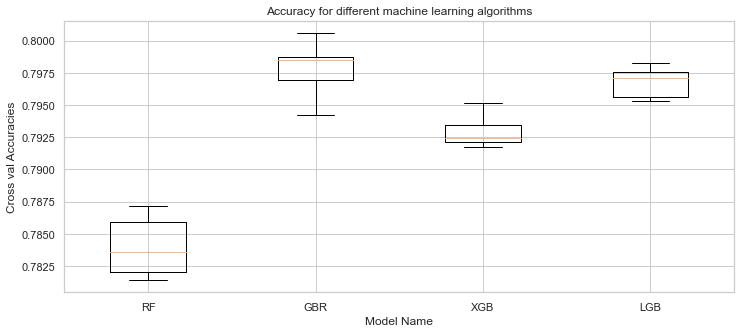

In [63]:
plt.figure(figsize=(12,5))
plt.boxplot(results)
plt.xticks(np.arange(1,len(names)+1),names)
plt.title("Accuracy for different machine learning algorithms")
plt.xlabel("Model Name")
plt.ylabel("Cross val Accuracies")
plt.show()

In [64]:
selected_pipe = Pipeline([('ct', ct), ('GBR', model_gbr)])
selected_pipe.fit(x_train, y_train)
trainpred = selected_pipe.predict(x_test)
print(classification_report(y_test, trainpred))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88     10118
           1       0.61      0.10      0.17      2754

    accuracy                           0.79     12872
   macro avg       0.70      0.54      0.53     12872
weighted avg       0.76      0.79      0.73     12872



## 3 . Refinement

To further improve the selected model, we can use the grid search

In [65]:
grid_param = {
    'GBR__n_estimators': [100, 200],
    'GBR__min_samples_split': [5,10,20],
    'GBR__learning_rate': [0.03,0.05]
}

gd_sr = GridSearchCV(estimator=selected_pipe,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)
gd_sr.fit(x_train, y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

{'GBR__learning_rate': 0.05, 'GBR__min_samples_split': 10, 'GBR__n_estimators': 200}


Training Data Score from the grid search model

In [66]:
gd_sr.score(x_train, y_train)

0.7993939864812369

Testing Data Score from the grid search model

In [67]:
gd_sr.score(x_test, y_test)

0.7936606587942822

# Section - Result

## 1. Model Evaluation and Validation

Next, in order to find the most contributing demographic features, we can try a correlation matrix

In [68]:
onehot_categories = gd_sr.get_params()["estimator"]['ct'].transformers_[0][1].categories_
onehot_features = [f"{col}__{val}" for col, vals in zip(cat_var1, onehot_categories) for val in vals]
all_features = onehot_features

correlation_matrix = pd.DataFrame(ct.transform(X), columns=all_features)
correlation_matrix = pd.concat([correlation_matrix,Y.reset_index()], axis=1).corr()
correlation_matrix = correlation_matrix.loc[["hasCompleted | hasViewed"]].T.sort_values("hasCompleted | hasViewed", ascending=False).T

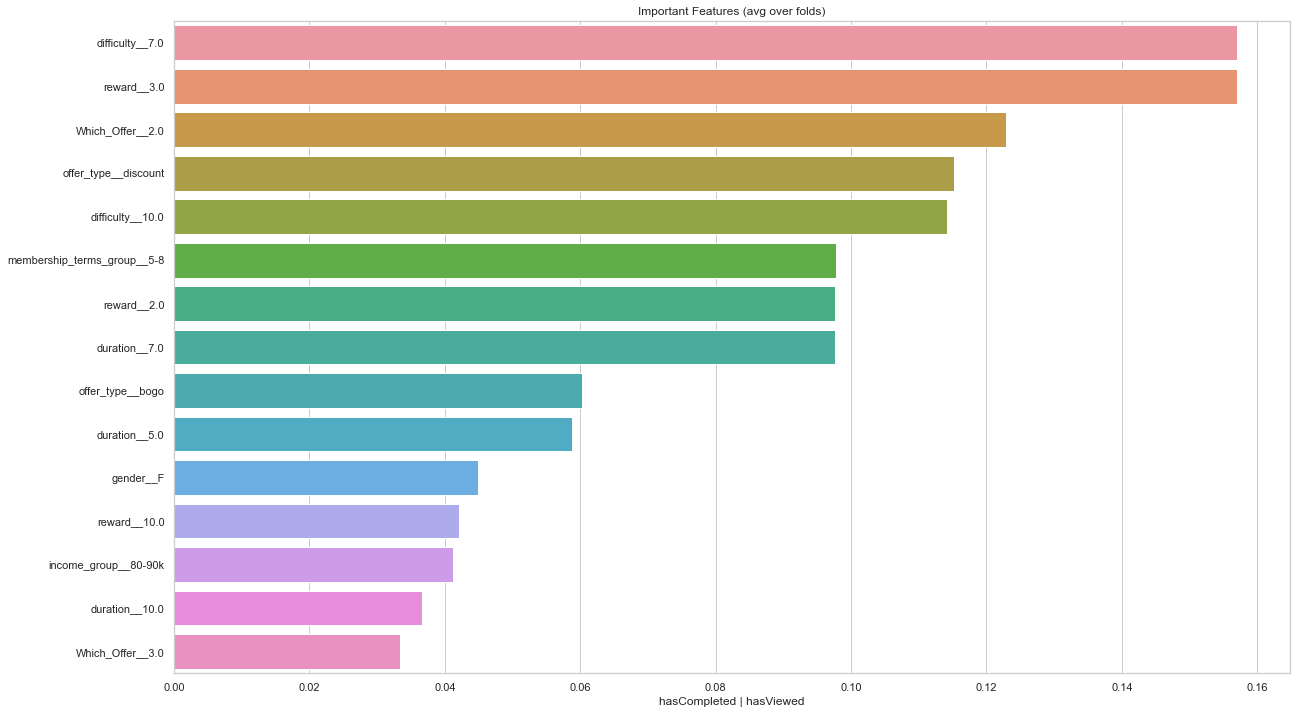

In [69]:
correlation_matrix.loc[["hasCompleted | hasViewed"]].T.sort_values("hasCompleted | hasViewed", ascending=False).T
plt.figure(figsize=(20, 12))
sns.barplot(y=correlation_matrix.columns[1:16], x=correlation_matrix.loc["hasCompleted | hasViewed"][1:16])
plt.title('Important Features (avg over folds)')
plt.show()

Looking at the overall summary of correlation, the demographic properties of consumers from the highest to lowest would suggest that female customers having a membership term between 5-8 years and with the income level of 80 k to 90 k are probably a good target. It could be hypothesized that these segments customers are likely to respond favorably to offers. 

In [70]:
result = []
for ii in x_test["income_group"].unique():
    for jj in x_test["membership_terms_group"].unique():
           for kk in x_test["gender"].unique():
                x_subtest = x_test[(x_test["income_group"]==ii) & (x_test["membership_terms_group"]==jj)& (x_test["gender"]==kk)]
                if len(x_subtest)==0:
                    score = 0
                   # print ("{} members with age_group {} and with membership term {} : Hit Rate {:2f} ".format(kk,ii,jj,score))
                    result.append([kk,jj,ii,score])
                    next 
                else :
                    score = gd_sr.predict(x_subtest).sum()/len(x_subtest)
                   # print ("{} members with age_group {} and with membership term {} : Hit Rate {:2f} ".format(kk,ii,jj,score)
                    result.append([kk,jj,ii,score])

result_df = pd.DataFrame(result, columns = ["gender","membership_terms_group","income_group","hit_rate"])
result_df.sort_values("hit_rate", ascending = False).head(10)

,gender,membership_terms_group,income_group,hit_rate
20,F,5-8,80-90k,0.196078
32,F,5-8,70-80k,0.194611
2,F,5-8,60-70k,0.193050
8,F,5-8,50-60k,0.174041
39,M,5-8,90-100k,0.158654
21,M,5-8,80-90k,0.115556
38,F,5-8,90-100k,0.080972
47,M,8-10,30-40k,0.058824
16,F,8-10,40-50k,0.055556
9,M,5-8,50-60k,0.043825


Let's try to model the effectiveness of such campaign over these segments of customers namely the female members, with membership terms between 6-8 years, and with the income level of 60k to 90 k. We will select the metric that will help to distinguish the difference to be Average Net Amount Spent (Average Amount Spent - Average Rebate claimed) on the transaction. To do that, the transaction data of females customers within 6 to 8 years into their membership and earns between 60 k to 90 k but were not sent any offers can be used as the control group, denoted as A. 

We have to recreate a new dataframe drom df_sub to include features like "reward_claimed" and "amount_spent" for later use. Essentially we perform similar data transfomation to how we obtain for model_df as above.

In [71]:
df_sub2 = df_sub.copy(deep=True)
amount_spent = df_sub2[["personxoffer_id","amount_spent"]][df_sub2.event=="transaction"]
amount_spent = dict(zip(amount_spent.personxoffer_id,amount_spent.amount_spent))
df_sub2["amount_spent"] = df_sub2["personxoffer_id"].map(amount_spent)
reward_claimed = df_sub2[["personxoffer_id","reward_claimed"]][df_sub.event=="offer completed"]
reward_claimed = dict(zip(reward_claimed.personxoffer_id,reward_claimed.reward_claimed))
df_sub2["reward_claimed"] = df_sub2["personxoffer_id"].map(reward_claimed)
df_sub2["reward_claimed"].replace(np.NaN,0,inplace=True)
df_sub2["net_amount_spent"] =df_sub2["amount_spent"] -df_sub2["reward_claimed"]
model_df2 = df_sub2.drop(["index","time","cum_count",
                          "personxoffer_id","person","offer_id","event","time_of_offer",
                           "channels","became_member_on","Transaction_From_Offer",
                           "hasViewed","Related_Offer_Id","transaction_completed","hasViewed_on_time","hasCompleted"], axis=1)

model_df2.drop_duplicates(inplace=True)

Performing na check :

In [72]:
model_df2.isna().sum()

amount_spent                11706
reward_claimed                  0
gender                       4790
age                          4790
income                       4790
Which_Offer                     0
reward                       2535
difficulty                   2535
duration                     2535
offer_type                   2535
membership_terms(y)          4790
hasCompleted | hasViewed        0
net_amount_spent            11706
dtype: int64

Remove na and performing na check again :

In [73]:
model_df2 = model_df2.dropna(subset=["gender","amount_spent"])
model_df2.isna().sum()

amount_spent                   0
reward_claimed                 0
gender                         0
age                            0
income                         0
Which_Offer                    0
reward                      2274
difficulty                  2274
duration                    2274
offer_type                  2274
membership_terms(y)            0
hasCompleted | hasViewed       0
net_amount_spent               0
dtype: int64

Note again that some na are found in ["reward","difficulty","duration","offer_type"] because these are transactions without underlying offers.

To bin the continuous variables into categorical variables again :

In [74]:
category=pd.cut(model_df2['age'], bins=[10,20,30,40,50,60,70,80,90,1000],labels = ["10-20","20-30","30-40","40-50","50-60","60-70","70-80","80-90",">90"])
model_df2.insert(1,"age_group",category)
category=pd.cut(model_df2['income'], 9,labels = ["30-40k","40-50k","50-60k","60-70k","70-80k","80-90k","90-100k","100-110k",">110k"])
model_df2.insert(2,"income_group",category)
category=pd.cut(model_df2['membership_terms(y)'], bins=[0,1,2,5,8,10,100],labels = ["<1","1-2","2-5","5-8","8-10",">10"])
model_df2.insert(3,"membership_terms_group",category)
model_df2 =model_df2.drop(["age","income",'membership_terms(y)'], axis=1)
model_df2= model_df2.drop(["reward","difficulty","duration","offer_type"], axis=1)
model_df2 = model_df2

In [75]:
model_df2

,amount_spent,age_group,income_group,membership_terms_group,reward_claimed,gender,Which_Offer,hasCompleted | hasViewed,net_amount_spent
0,22.16,30-40,70-80k,2-5,0.0,M,1.0,0,22.16
5,8.57,30-40,70-80k,2-5,5.0,M,1.0,0,3.57
9,13.56,30-40,70-80k,2-5,2.0,M,1.0,0,11.56
14,18.41,30-40,70-80k,2-5,2.0,M,1.0,0,16.41
45,24.31,50-60,80-90k,5-8,2.0,F,1.0,1,22.31
...,...,...,...,...,...,...,...,...,...
306496,7.06,30-40,30-40k,2-5,5.0,M,1.0,0,2.06
306501,9.12,40-50,60-70k,5-8,2.0,F,1.0,1,7.12
306507,16.86,40-50,60-70k,5-8,5.0,F,1.0,1,11.86
306515,18.91,40-50,60-70k,5-8,2.0,F,1.0,1,16.91


Define control_group_A as transactions without any linked offers, and control_group_B as transaction with linked offers. 

In [76]:
control_group_A = model_df2[model_df2.Which_Offer == 100]
control_group_B = model_df2[(model_df2["hasCompleted | hasViewed"]==1) & (model_df2.Which_Offer != 100)]

In [77]:
control_group_C = model_df2[(model_df2.Which_Offer != 100)]

In [78]:
control_group_A

,amount_spent,age_group,income_group,membership_terms_group,reward_claimed,gender,Which_Offer,hasCompleted | hasViewed,net_amount_spent
64,16.27,20-30,50-60k,5-8,0.0,F,100.0,0,16.27
142,25.62,50-60,70-80k,2-5,0.0,F,100.0,0,25.62
478,1.88,20-30,50-60k,2-5,0.0,M,100.0,0,1.88
551,11.80,60-70,70-80k,2-5,0.0,F,100.0,0,11.80
719,4.40,30-40,30-40k,2-5,0.0,M,100.0,0,4.40
...,...,...,...,...,...,...,...,...,...
305887,4.12,50-60,50-60k,5-8,0.0,M,100.0,0,4.12
305997,23.96,70-80,90-100k,2-5,0.0,M,100.0,0,23.96
306223,5.84,30-40,60-70k,2-5,0.0,M,100.0,0,5.84
306387,18.66,60-70,70-80k,2-5,0.0,M,100.0,0,18.66


In [79]:
print("Control Group A : Non Offer Linked Purchases Net Spent from Target Segment Customers = $%.3f"%(control_group_A[((control_group_A["income_group"]=="60-70k") | (control_group_A["income_group"]=="70-80k") | (control_group_A["income_group"]=="80-90k")) & ((control_group_A["gender"]=="F") & (control_group_A["membership_terms_group"]=="5-8"))].agg(np.mean)["net_amount_spent"]))
print("Control Group A : Non Offer Linked Purchases from Target Segments Customer/Total Non Offer Linked Purchases = %.4f"%(len(control_group_A[((control_group_A["income_group"]=="60-70k") | (control_group_A["income_group"]=="70-80k") | (control_group_A["income_group"]=="80-90k")) & ((control_group_A["gender"]=="F") & (control_group_A["membership_terms_group"]=="5-8"))])/len(control_group_A)))
print("Control Group B : Offer Linked Purchases Net Spent from Target Segment Customers = $%.3f"%(control_group_B[((control_group_B["income_group"]=="60-70k") | (control_group_B["income_group"]=="70-80k") | (control_group_B["income_group"]=="80-90k")) & ((control_group_B["gender"]=="F") & (control_group_B["membership_terms_group"]=="5-8"))].agg(np.mean)["net_amount_spent"]))
print("Control Group B : Offer Linked Purchases from Target Segment Customers/Total Offer Linked Purchases = %.4f"%(len(control_group_B[((control_group_B["income_group"]=="60-70k") | (control_group_B["income_group"]=="70-80k") | (control_group_B["income_group"]=="80-90k")) & ((control_group_B["gender"]=="F") & (control_group_B["membership_terms_group"]=="5-8"))])/len(control_group_B)))
print("Control Group C : Number of Offer Receiving Target Segment Customers/Total Number of Offer Receiving Target Segment Customers = %.4f"%(len(control_group_C[((control_group_C["income_group"]=="60-70k") | (control_group_C["income_group"]=="70-80k") | (control_group_C["income_group"]=="80-90k")) & ((control_group_C["gender"]=="F") & (control_group_C["membership_terms_group"]=="5-8"))])/len(control_group_C)))

Control Group A : Non Offer Linked Purchases Net Spent from Target Segment Customers = $18.931
Control Group A : Non Offer Linked Purchases from Target Segments Customer/Total Non Offer Linked Purchases = 0.0638
Control Group B : Offer Linked Purchases Net Spent from Target Segment Customers = $17.350
Control Group B : Offer Linked Purchases from Target Segment Customers/Total Offer Linked Purchases = 0.1009
Control Group C : Number of Offer Receiving Target Segment Customers/Total Number of Offer Receiving Target Segment Customers = 0.0747


In [80]:
ave_net_spend_A = control_group_A[((control_group_A["income_group"]=="60-70k") | (control_group_A["income_group"]=="70-80k") | (control_group_A["income_group"]=="80-90k")) & ((control_group_A["gender"]=="F") & (control_group_A["membership_terms_group"]=="5-8"))]["net_amount_spent"]

ave_net_spend_B = control_group_B[((control_group_B["income_group"]=="60-70k") | (control_group_B["income_group"]=="70-80k") | (control_group_B["income_group"]=="80-90k")) & ((control_group_B["gender"]=="F") & (control_group_B["membership_terms_group"]=="5-8"))]["net_amount_spent"]

In [81]:
t_value,p_value = stats.ttest_ind(a=ave_net_spend_A.to_numpy(), b=ave_net_spend_B.to_numpy(), equal_var=True)

In [82]:
print('Test statistic is %f'%float("{:.6f}".format(t_value)))
print('p-value for two tailed test is %f'%p_value)

alpha = 0.05

if p_value<=alpha:
    print('Conclusion','n','Since p-value(=%f)'%p_value,'<','alpha(=%.2f)'%alpha,'''We reject the null hypothesis H0. So we conclude that the 
means are not equal i.e., μ1 = μ2 at %.2f level of significance.'''%alpha)

else:
    print('Conclusion :','Since p-value(=%f)'%p_value,'>','alpha(=%.2f)'%alpha,'''We do not reject the null hypothesis H0.''')

Test statistic is 0.451088
p-value for two tailed test is 0.652003
Conclusion : Since p-value(=0.652003) > alpha(=0.05) We do not reject the null hypothesis H0.


In [83]:
#--end--